In [2]:
!conda create -n myenv python=3.8 -y

Solving environment: - failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 24.11.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda/envs/myenv

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB
    ca-certificates-2024.12.31 |       h06a4308_0         128 KB
    ld_impl_linux-64-2.40      |       h12ee557_0         710 KB
    libffi-3.3                 |       he6710b0_2          50 KB
    libgcc-ng-9.1.0            |       hdf63c60_0         5.1 MB
    libstdcxx-ng-9.1.0         |       hdf63c60_0         3.1 MB
    ncurses-6.3     

In [4]:
!pip install --upgrade transformers timm


     |████████████████████████████████| 4.0MB 8.7MB/s 
     |████████████████████████████████| 552kB 42.8MB/s 
     |████████████████████████████████| 6.6MB 50.2MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 880kB 44.4MB/s 
     |████████████████████████████████| 40kB 4.5MB/s 
     |████████████████████████████████| 881.9MB 14kB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-cp36-none-any.whl size=895254 sha256=294d7b2935f6a5853bcbc4247a55baa83fd252c7db7e0c49402e6b54e5bdbdc7
  Stored in directory: /root/.cache/pip/wheels/56/d5/b2/bc878b2bbddfbcc8fd62ca73c4fd842bd28c1fd3dbdf424c74
Successfully built sacremoses
ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 4.1.1 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0,

In [6]:
!pip install --upgrade transformers


Requirement already up-to-date: transformers in /opt/conda/lib/python3.6/site-packages (4.18.0)


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import random
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import os 

metadata_path = '/kaggle/input/dfdc-48/dfdc_train_part_48/metadata.json'
input_dir = '/kaggle/input/dfdc-48/dfdc_train_part_48'


base_dir = '/kaggle/working/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


def create_split_subdirs(split_dir):
    real_dir = os.path.join(split_dir, 'real')
    fake_dir = os.path.join(split_dir, 'fake')
    real_frame_dir = os.path.join(split_dir, 'real_frame')
    fake_frame_dir = os.path.join(split_dir, 'fake_frame')
    
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)
    os.makedirs(real_frame_dir, exist_ok=True)
    os.makedirs(fake_frame_dir, exist_ok=True)
    
    return real_dir, fake_dir, real_frame_dir, fake_frame_dir

In [ ]:

for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)
    create_split_subdirs(split_dir)


import json
with open(metadata_path, 'r') as f:
    metadata = json.load(f)


input_dir = '/kaggle/input/dfdc-48/dfdc_train_part_48'


import random
from sklearn.model_selection import train_test_split

In [11]:
def split_videos(sample_size=10):
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    real_videos, fake_videos = [], []

    for video_name, data in metadata.items():
        video_path = os.path.join(input_dir, video_name)
        if os.path.exists(video_path):
            if data['label'] == 'REAL':
                real_videos.append((video_path, 'real'))
            elif data['label'] == 'FAKE':
                fake_videos.append((video_path, 'fake'))

    real_videos = random.sample(real_videos, min(len(real_videos), sample_size))
    fake_videos = random.sample(fake_videos, min(len(fake_videos), sample_size))

    all_videos = real_videos + fake_videos
    labels = [1 if v[1] == 'real' else 0 for v in all_videos]

    train_videos, temp_videos, train_labels, temp_labels = train_test_split(
        all_videos, labels, test_size=0.3, stratify=labels, random_state=42)
    val_videos, test_videos, val_labels, test_labels = train_test_split(
        temp_videos, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
    
    return train_videos, val_videos, test_videos


In [ ]:

import shutil
def copy_videos_to_split_dirs(videos, split_dir):
    real_dir, fake_dir, _, _ = create_split_subdirs(split_dir)
    
    for video_path, label in videos:
        target_dir = real_dir if label == 'real' else fake_dir
        video_name = os.path.basename(video_path)
        shutil.copy(video_path, os.path.join(target_dir, video_name))
        print(f"Copied {video_name} to {target_dir}")

train_videos, val_videos, test_videos = split_videos()
copy_videos_to_split_dirs(train_videos, train_dir)
copy_videos_to_split_dirs(val_videos, val_dir)
copy_videos_to_split_dirs(test_videos, test_dir)

Copied uuyyezfcnx.mp4 to /kaggle/working/dataset/train/real
Copied bzsxxqcyny.mp4 to /kaggle/working/dataset/train/fake
Copied qcbbixyego.mp4 to /kaggle/working/dataset/train/real
Copied srtwhbzzlr.mp4 to /kaggle/working/dataset/train/fake
Copied sotclwmskg.mp4 to /kaggle/working/dataset/train/real
Copied mhvebxvhsx.mp4 to /kaggle/working/dataset/train/real
Copied jxnhuoofmp.mp4 to /kaggle/working/dataset/train/fake
Copied ewglmznvxe.mp4 to /kaggle/working/dataset/train/fake
Copied evirwnkqms.mp4 to /kaggle/working/dataset/train/real
Copied jnvycbkaph.mp4 to /kaggle/working/dataset/train/real
Copied yjoxcezfmk.mp4 to /kaggle/working/dataset/train/fake
Copied idwhtnofel.mp4 to /kaggle/working/dataset/train/real
Copied sbrjiwfrtg.mp4 to /kaggle/working/dataset/train/fake
Copied pnghtmxjhy.mp4 to /kaggle/working/dataset/train/fake
Copied oxbcpirwua.mp4 to /kaggle/working/dataset/validation/real
Copied gsxlolioxh.mp4 to /kaggle/working/dataset/validation/real
Copied ayqetwwwjn.mp4 to /kagg

In [ ]:

def extract_faces_from_videos(split_dir, frame_skip=10):
    real_dir, fake_dir, real_frame_dir, fake_frame_dir = create_split_subdirs(split_dir)
    
    
    for video_name in os.listdir(real_dir):
        video_path = os.path.join(real_dir, video_name)
        if os.path.isfile(video_path):
            extract_faces_from_video(video_path, real_frame_dir, frame_skip)
    
    
    for video_name in os.listdir(fake_dir):
        video_path = os.path.join(fake_dir, video_name)
        if os.path.isfile(video_path):
            extract_faces_from_video(video_path, fake_frame_dir, frame_skip)

In [ ]:

def extract_faces_from_video(video_path, output_dir, frame_skip=10):
    import cv2
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    face_count = 0

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % frame_skip != 0:
            continue

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, 1.1, 4)

        for i, (x, y, w, h) in enumerate(faces):
            face = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (224, 224))
            output_path = os.path.join(output_dir, f"{os.path.basename(video_path)}_frame{frame_count}_face{i}.jpg")
            cv2.imwrite(output_path, face_resized)
            face_count += 1
    cap.release()
    print(f"{video_path}: {face_count} faces extracted.")


In [ ]:

print("\nExtracting frames from training set...")
extract_faces_from_videos(train_dir)
print("\nExtracting frames from validation set...")
extract_faces_from_videos(val_dir)
print("\nExtracting frames from test set...")
extract_faces_from_videos(test_dir)


Extracting frames from training set...
/kaggle/working/dataset/train/real/jnvycbkaph.mp4: 31 faces extracted.
/kaggle/working/dataset/train/real/evirwnkqms.mp4: 35 faces extracted.
/kaggle/working/dataset/train/real/idwhtnofel.mp4: 25 faces extracted.
/kaggle/working/dataset/train/real/mhvebxvhsx.mp4: 32 faces extracted.
/kaggle/working/dataset/train/real/sotclwmskg.mp4: 32 faces extracted.
/kaggle/working/dataset/train/real/uuyyezfcnx.mp4: 8 faces extracted.
/kaggle/working/dataset/train/real/qcbbixyego.mp4: 0 faces extracted.
/kaggle/working/dataset/train/fake/pnghtmxjhy.mp4: 63 faces extracted.
/kaggle/working/dataset/train/fake/bzsxxqcyny.mp4: 96 faces extracted.
/kaggle/working/dataset/train/fake/ewglmznvxe.mp4: 66 faces extracted.
/kaggle/working/dataset/train/fake/yjoxcezfmk.mp4: 33 faces extracted.
/kaggle/working/dataset/train/fake/jxnhuoofmp.mp4: 59 faces extracted.
/kaggle/working/dataset/train/fake/sbrjiwfrtg.mp4: 87 faces extracted.
/kaggle/working/dataset/train/fake/srtw

In [ ]:
from PIL import Image
import os

def normalize_images(input_dir, output_dir, image_size=224):
    os.makedirs(output_dir, exist_ok=True)
    
    for img_name in os.listdir(input_dir):
        try:
            img_path = os.path.join(input_dir, img_name)
            img = Image.open(img_path).convert('RGB')  
            img = img.resize((image_size, image_size))  
            img.save(os.path.join(output_dir, img_name))  
        except Exception as e:
            print(f"Error occurred: {img_name} - {e}")


normalize_images(train_dir+"/fake_frame","norm_train_dir/fake")
normalize_images(train_dir+"/real_frame","norm_train_dir/real")
normalize_images(test_dir+"/fake_frame","norm_test_dir/fake")
normalize_images(test_dir+"/real_frame","norm_test_dir/real")
normalize_images(val_dir+"/fake_frame","norm_val_dir/fake")
normalize_images(val_dir+"/real_frame","norm_val_dir/real")


In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FaceDataset(Dataset):
    def __init__(self, norm_dir, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        
        real_dir = os.path.join(norm_dir, 'real')
        fake_dir = os.path.join(norm_dir, 'fake')
        
        
        if os.path.exists(real_dir):
            for img_name in os.listdir(real_dir):
                img_path = os.path.join(real_dir, img_name)
                if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append(img_path)
                    self.labels.append(0)  
        
        
        if os.path.exists(fake_dir):
            for img_name in os.listdir(fake_dir):
                img_path = os.path.join(fake_dir, img_name)
                if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append(img_path)
                    self.labels.append(1)  

        
        if len(self.data) == 0:
            print(f"Warning: No data found in the directory {norm_dir}!")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            img = Image.new('RGB', (224, 224))

        if self.transform:
            img = self.transform(img)

        return img, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = FaceDataset("norm_train_dir", transform=transform)
test_dataset = FaceDataset("norm_test_dir", transform=transform)
val_dataset = FaceDataset("norm_val_dir", transform=transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

if len(train_dataset) == 0 or len(test_dataset) == 0 or len(val_dataset) == 0:
    raise ValueError("Dataset is empty. Please check the data paths.")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print("Data loaders successfully created.")

Train veri sayısı: 666
Test veri sayısı: 141
Validation veri sayısı: 97
Veri yükleyiciler başarıyla oluşturuldu.


In [ ]:

import timm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model.head = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(in_features=768, out_features=2)
)
vit_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        
        model.train()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            
            optimizer.zero_grad()
            
            
            outputs = model(images)
            
            
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_samples
        
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    
    history = {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies
    }
    
    return history

def evaluate_model(model, loader, criterion):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [ ]:

def test_model(model, test_loader, criterion):
    print("\nEvaluating on the test set...")
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy
    
def evaluate_train_data(model, train_loader):
    model.eval()  
    correct_predictions = 0
    total_samples = 0
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")

In [ ]:

def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}.")


def load_model(file_path, model):
    model.load_state_dict(torch.load(file_path))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {file_path}.")
    return model


In [ ]:

from torch.optim.lr_scheduler import ReduceLROnPlateau


In [ ]:

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):

        self.patience = patience
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [ ]:
%%time

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


vit_model = vit_model.to(device)


early_stopping = EarlyStopping(patience=40, verbose=True)


history = []

num_epochs = 10
for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples

    
    val_loss, val_accuracy = evaluate_model(vit_model, val_loader, criterion)

    
    scheduler.step(val_loss)

    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    
    history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

    print(f"Epoch [{epoch+1}/10] | "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Model trained successfully!")

Epoch [1/10] | Train Loss: 0.3423, Train Accuracy: 0.8844 | Validation Loss: 2.0446, Validation Accuracy: 0.7216
Epoch [2/10] | Train Loss: 0.1526, Train Accuracy: 0.9474 | Validation Loss: 0.7547, Validation Accuracy: 0.7835
EarlyStopping counter: 1/40
Epoch [3/10] | Train Loss: 0.1018, Train Accuracy: 0.9670 | Validation Loss: 1.0258, Validation Accuracy: 0.6082
EarlyStopping counter: 2/40
Epoch [4/10] | Train Loss: 0.0643, Train Accuracy: 0.9685 | Validation Loss: 2.6662, Validation Accuracy: 0.7216
EarlyStopping counter: 3/40
Epoch [5/10] | Train Loss: 0.0524, Train Accuracy: 0.9835 | Validation Loss: 1.8870, Validation Accuracy: 0.7216
Epoch     6: reducing learning rate of group 0 to 5.0000e-06.
EarlyStopping counter: 4/40
Epoch [6/10] | Train Loss: 0.0728, Train Accuracy: 0.9790 | Validation Loss: 1.4551, Validation Accuracy: 0.7320
EarlyStopping counter: 5/40
Epoch [7/10] | Train Loss: 0.0293, Train Accuracy: 0.9865 | Validation Loss: 2.2121, Validation Accuracy: 0.7113
EarlySt

In [ ]:
test_loss, test_accuracy = test_model(vit_model, test_loader, criterion)


Test seti üzerinde değerlendiriliyor...
Test Loss: 8.2367, Test Accuracy: 0.2199


In [ ]:

save_model(vit_model, '/kaggle/working/vit_deepfake.pth')

Model /kaggle/working/vit_deepfake.pth konumuna kaydedildi.


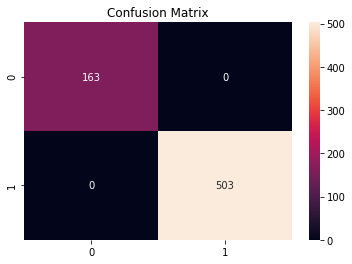

Accuracy: 1.00
F1 Score: 1.00
AUC: 1.00


In [ ]:

vit_model.eval()
y_true = []
y_pred = []
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = vit_model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
print(f"AUC: {roc_auc_score(y_true, y_pred):.2f}")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


y_true = []
y_pred = []

vit_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


cr = classification_report(y_true, y_pred)
print("Classification Report:\n", cr)

Confusion Matrix:
 [[ 0 97]
 [13 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.24      0.70      0.36        44

    accuracy                           0.22       141
   macro avg       0.12      0.35      0.18       141
weighted avg       0.08      0.22      0.11       141



In [ ]:
import torch
import cv2
import os
from torchvision import transforms
from PIL import Image
import numpy as np

def test_video(video_path, vit_model, transform, device, frame_skip=10):

    vit_model.eval()  
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    predictions = []

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  
        
        frame_count += 1
        
        
        if frame_count % frame_skip != 0:
            continue

        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, 1.1, 4)

        
        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (224, 224))
            
            
            face_pil = Image.fromarray(face_resized).convert('RGB')
            face_tensor = transform(face_pil).unsqueeze(0).to(device)
            
            
            with torch.no_grad():
                outputs = vit_model(face_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_class = torch.argmax(probabilities, dim=1).item()
                predictions.append(predicted_class)
    
    cap.release()

    
    if len(predictions) == 0:
        return "Unknown", 0.0

    
    real_count = predictions.count(0)
    fake_count = predictions.count(1)
    confidence = fake_count / len(predictions)
    
    if fake_count > real_count:
        return "FAKE", confidence
    else:
        return "REAL", 1 - confidence

In [ ]:

test_video_path = '/kaggle/input/dfdc-48/dfdc_train_part_48/eukxkhumll.mp4'


result, confidence = test_video(test_video_path, vit_model, transform, device)

print(f"Prediction: {result}, Confidence Score: {confidence:.2f}")


Tahmin: FAKE, Güven Puanı: 0.56


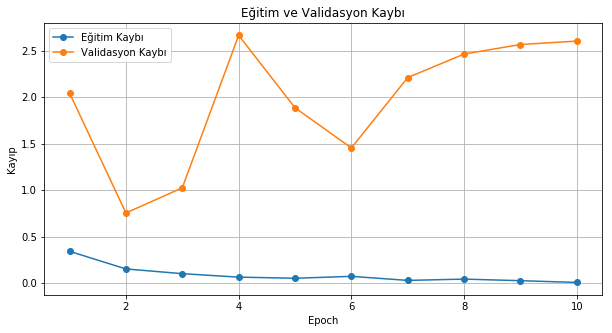

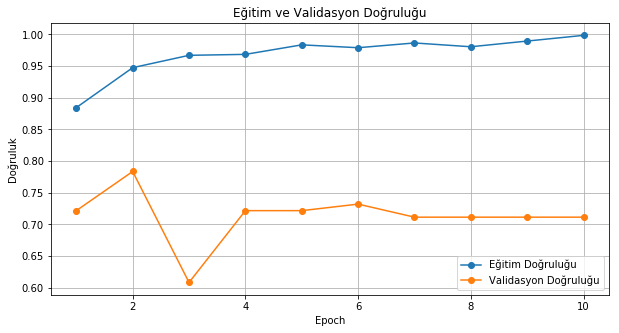

In [ ]:
import matplotlib.pyplot as plt

epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
val_loss = [h['val_loss'] for h in history]
train_accuracy = [h['train_accuracy'] for h in history]
val_accuracy = [h['val_accuracy'] for h in history]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label="Training Accuracy", marker='o')
plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker='o')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import torch

def calculate_auc_f1(model, data_loader, device):

    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            if len(batch) == 2:
                images, labels = batch
            elif len(batch) == 3:
                images, labels, _ = batch  
            else:
                raise ValueError("Unexpected number of elements in batch.")
                
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

    auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, [1 if p > 0.5 else 0 for p in all_preds])
    return auc, f1



In [ ]:

train_auc, train_f1 = calculate_auc_f1(vit_model, train_loader, device)
print(f"Training AUC: {train_auc:.4f}, Training F1 Score: {train_f1:.4f}")


Training AUC: 1.0000, Training F1 Score: 1.0000


In [ ]:

val_auc, val_f1 = calculate_auc_f1(vit_model, val_loader, device)
print(f"Validation AUC: {val_auc:.4f}, Validation F1 Score: {val_f1:.4f}")

Validation AUC: 0.5143, Validation F1 Score: 0.4815


In [ ]:

test_auc, test_f1 = calculate_auc_f1(vit_model, test_loader, device)
print(f"Test AUC: {test_auc:.4f}, Test F1 Score: {test_f1:.4f}")

Test AUC: 0.1429, Test F1 Score: 0.3605
